In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels import PanelOLS
import statsmodels.api as sm

In [2]:
df = pd.read_csv('data/data.csv')

In [3]:
trend_co2 = df.groupby('year').Intensity_tot.mean().to_frame().reset_index(drop=False)
trend_co2['Co2_tot'] = df.groupby('year').Co2_tot.mean().values
trend_co2['year'] = pd.to_datetime(trend_co2['year'])

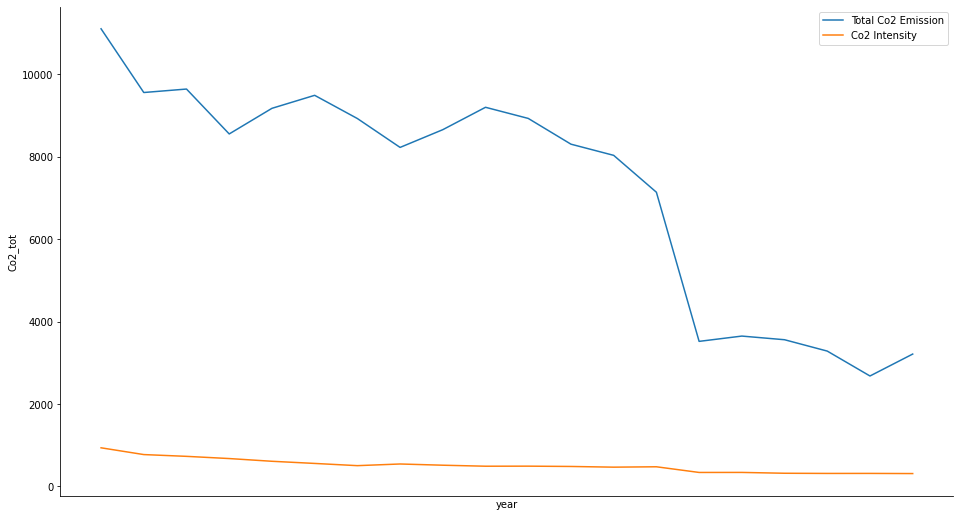

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.lineplot(x=trend_co2['year'], y=trend_co2['Co2_tot']/1000, ax=ax, label='Total Co2 Emission')
sns.lineplot(x=trend_co2['year'], y=trend_co2['Intensity_tot'], ax=ax, label='Co2 Intensity')

sns.despine()
plt.show()

In [22]:
# construct greeness with co2_total
df['greenness_1'] = df.groupby('year_month')['Co2_tot'].transform(lambda x: pd.qcut(x, q=3, labels=range(1,4)))

# compute weights
df['mc_sum_1'] = df.groupby(['year_month', 'greenness_1']).Marketcap.transform('sum')
df['weights_1'] = df.Marketcap / df.mc_sum_1

# value weighted returns
df['vw_return_1'] = df.RET * df.weights_1

# value weighted return for portfolios with different greenness
vw_return_1 = df.groupby(['year_month', 'greenness_1'])['vw_return_1'].sum().to_frame().reset_index()

# pivot to wide data
vw_return_1_wide = vw_return_1.pivot(index='year_month', columns='greenness_1', values='vw_return_1').reset_index()

vw_return_1_wide.columns = ['year_month', 'Green', 'netural_1', 'Brown']

vw_return_1_wide[['Green', 'netural_1', 'Brown']] = vw_return_1_wide[['Green', 'netural_1', 'Brown']].cumsum()
vw_return_1_wide['year_month'] = pd.to_datetime(vw_return_1_wide['year_month'], format='%Y-%m')

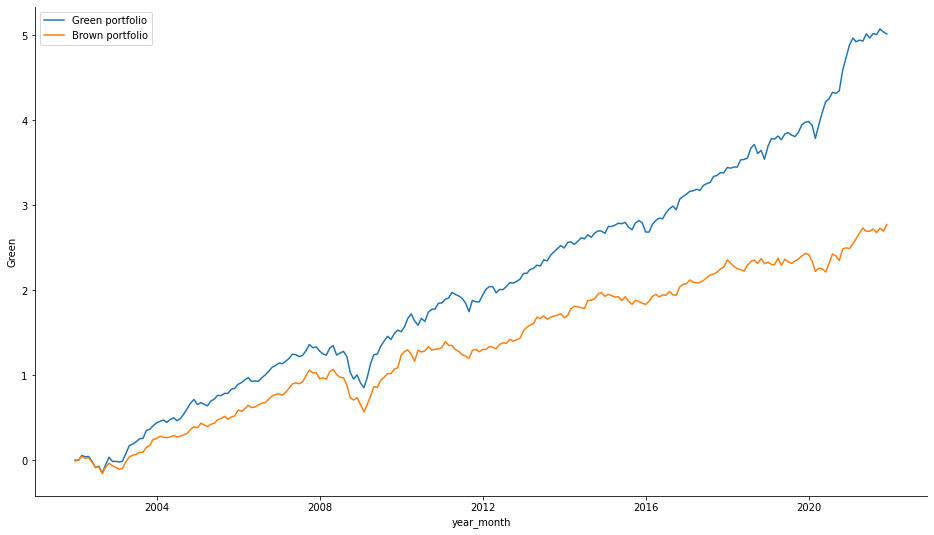

In [23]:

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.lineplot(data=vw_return_1_wide, x='year_month', y='Green', ax=ax, label='Green portfolio')
sns.lineplot(data=vw_return_1_wide, x='year_month', y='Brown', ax=ax, label='Brown portfolio')

sns.despine()
plt.show()

In [25]:
# construct greeness with intensity
df['greenness_2'] = df.groupby('year_month')['Intensity_tot'].transform(lambda x: pd.qcut(x, q=3, labels=range(1,4)))

# compute weights
df['mc_sum_2'] = df.groupby(['year_month', 'greenness_2']).Marketcap.transform('sum')
df['weights_2'] = df.Marketcap / df.mc_sum_2

# value weighted returns
df['vw_return_2'] = df.RET * df.weights_2

# value weighted return for portfolios with different greenness
vw_return_2 = df.groupby(['year_month', 'greenness_2'])['vw_return_2'].sum().to_frame().reset_index()

# pivot to wide data
vw_return_2_wide = vw_return_2.pivot(index='year_month', columns='greenness_2', values='vw_return_2').reset_index()

vw_return_2_wide.columns = ['year_month', 'Green', 'netural_2', 'Brown']

vw_return_2_wide[['Green', 'netural_2', 'Brown']] = vw_return_2_wide[['Green', 'netural_2', 'Brown']].cumsum()
vw_return_2_wide['year_month'] = pd.to_datetime(vw_return_2_wide['year_month'], format='%Y-%m')

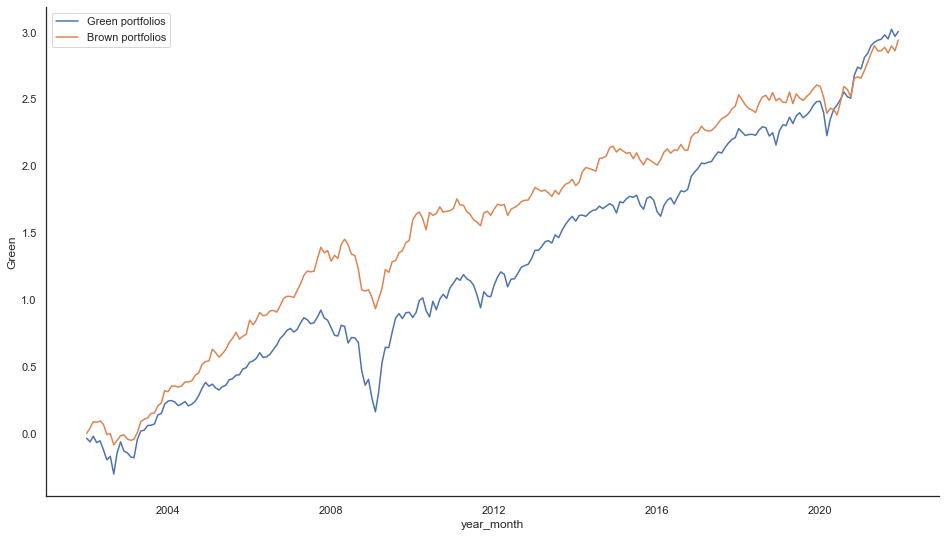

In [27]:
sns.set_theme(style='white')
fig, axe = plt.subplots(1,1, figsize=(16,9))

sns.lineplot(vw_return_2_wide, x='year_month', y='Green', label='Green portfolios')
sns.lineplot(vw_return_2_wide, x='year_month', y='Brown', label='Brown portfolios')

sns.despine()

### Industry Emission Ranking

In [28]:
industry = df.groupby('industry')['Co2_tot'].mean().to_frame()

industry = industry.reset_index()
industry = industry.sort_values('Co2_tot', ascending=False)

industry['rank'] = np.arange(1, len(industry) + 1)

industry['co2_total'] = industry['Co2_tot'].div(1000000).round(2)
industry = industry[['rank', 'industry', 'co2_total']]
industry.columns = ['Rank', 'GICS Industry Name', 'Total CO2 Emission']

In [31]:
industry_rank = pd.concat([industry[industry['Rank']<=33].reset_index(drop=True), industry[industry['Rank']>33].reset_index(drop=True)], axis=1).to_latex('analysis_result/industry_rank.tex', index=False)

C:\Users\wangc\AppData\Local\Temp\ipykernel_11728\535689248.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  industry_rank = pd.concat([industry[industry['Rank']<=33].reset_index(drop=True), industry[industry['Rank']>33].reset_index(drop=True)], axis=1).to_latex('analysis_result/industry_rank.tex', index=False)


In [14]:
# whole sample average CO2 emissions
df.Co2_tot.mean() / 1000000

4.644490769837641

In [15]:
# whole sample median CO2 emissions
df.Co2_tot.median() / 1000000

0.2662833270026144

### Return distribution based on Co2 total


In [48]:
df['RET'] = df.RET * 100

In [49]:
df['percentiles'] = df.Co2_tot.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
co2_tot = df.groupby('percentiles').RET.mean().to_frame()

df['percentiles'] = df.Co2_scope1.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
co2_scope1 = df.groupby('percentiles').RET.mean().to_frame()

df['percentiles'] = df.Co2_scope2.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
co2_scope2 = df.groupby('percentiles').RET.mean().to_frame()

df['percentiles'] = df.Co2_scope3.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
co2_scope3 = df.groupby('percentiles').RET.mean().to_frame()

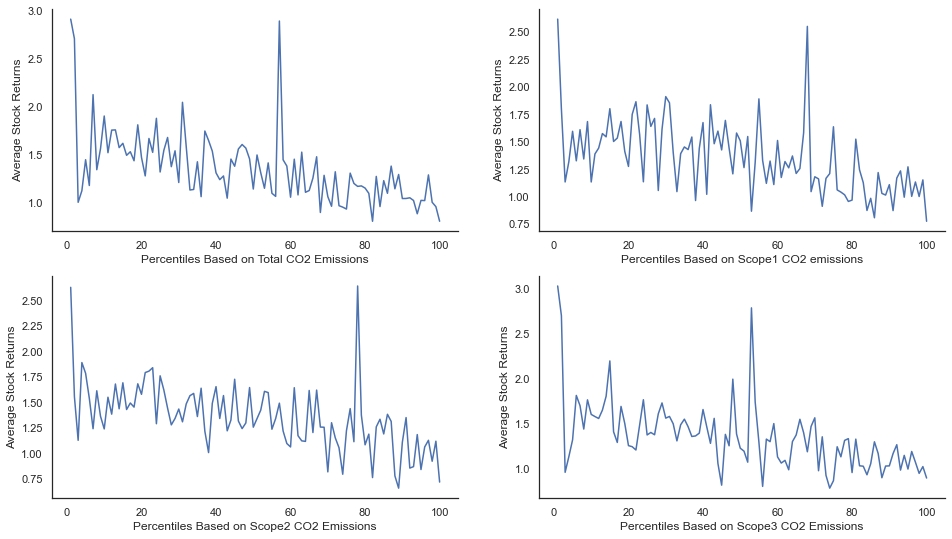

In [50]:
sns.set_theme(style='white')
fig, axe = plt.subplots(2,2, figsize=(16,9))

sns.lineplot(co2_tot, ax=axe[0,0], legend=False)
axe[0,0].set_xlabel('Percentiles Based on Total CO2 Emissions')
axe[0,0].set_ylabel('Average Stock Returns')

sns.lineplot(co2_scope1, ax=axe[0,1], legend=False)
axe[0,1].set_xlabel('Percentiles Based on Scope1 CO2 emissions')
axe[0,1].set_ylabel('Average Stock Returns')

sns.lineplot(co2_scope2, ax=axe[1,0], legend=False)
axe[1,0].set_xlabel('Percentiles Based on Scope2 CO2 Emissions')
axe[1,0].set_ylabel('Average Stock Returns')

sns.lineplot(co2_scope3, ax=axe[1,1], legend=False)
axe[1,1].set_xlabel('Percentiles Based on Scope3 CO2 Emissions')
axe[1,1].set_ylabel('Average Stock Returns')
sns.despine()

In [52]:
df['percentiles'] = df.Intensity_tot.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
intensity_tot = df.groupby('percentiles').RET.mean().to_frame()

df['percentiles'] = df.Intensity_scope1.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
intensity_scope1 = df.groupby('percentiles').RET.mean().to_frame()

df['percentiles'] = df.Intensity_scope2.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
intensity_scope2 = df.groupby('percentiles').RET.mean().to_frame()

df['percentiles'] = df.Intensity_scope3.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
intensity_scope3 = df.groupby('percentiles').RET.mean().to_frame()

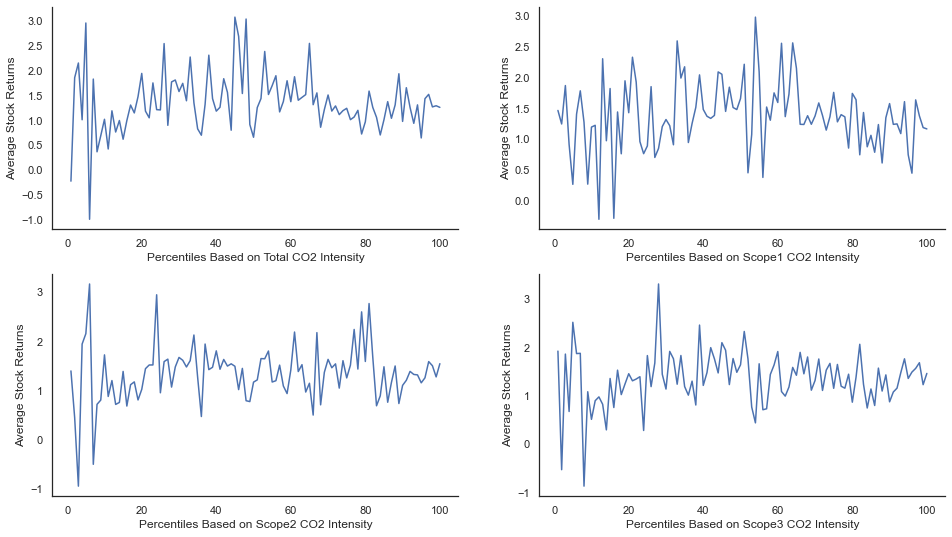

In [56]:
sns.set_theme(style='white')
fig, axe = plt.subplots(2,2, figsize=(16,9))

sns.lineplot(intensity_tot, ax=axe[0,0], legend=False)
axe[0,0].set_xlabel('Percentiles Based on Total CO2 Intensity')
axe[0,0].set_ylabel('Average Stock Returns')

sns.lineplot(intensity_scope1, ax=axe[0,1], legend=False)
axe[0,1].set_xlabel('Percentiles Based on Scope1 CO2 Intensity')
axe[0,1].set_ylabel('Average Stock Returns')

sns.lineplot(intensity_scope2, ax=axe[1,0], legend=False)
axe[1,0].set_xlabel('Percentiles Based on Scope2 CO2 Intensity')
axe[1,0].set_ylabel('Average Stock Returns')

sns.lineplot(intensity_scope3, ax=axe[1,1], legend=False)
axe[1,1].set_xlabel('Percentiles Based on Scope3 CO2 Intensity')
axe[1,1].set_ylabel('Average Stock Returns')
sns.despine()

In [39]:
df['percentiles'] = df.Marketcap.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
Marketcap = df.groupby('percentiles').RET.mean().to_frame()

df['percentiles'] = df.Levarage.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
Levarage = df.groupby('percentiles').RET.mean().to_frame()

df['percentiles'] = df.RoE.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
RoE = df.groupby('percentiles').RET.mean().to_frame()

df['percentiles'] = df.SaleGR.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
SaleGR = df.groupby('percentiles').RET.mean().to_frame()

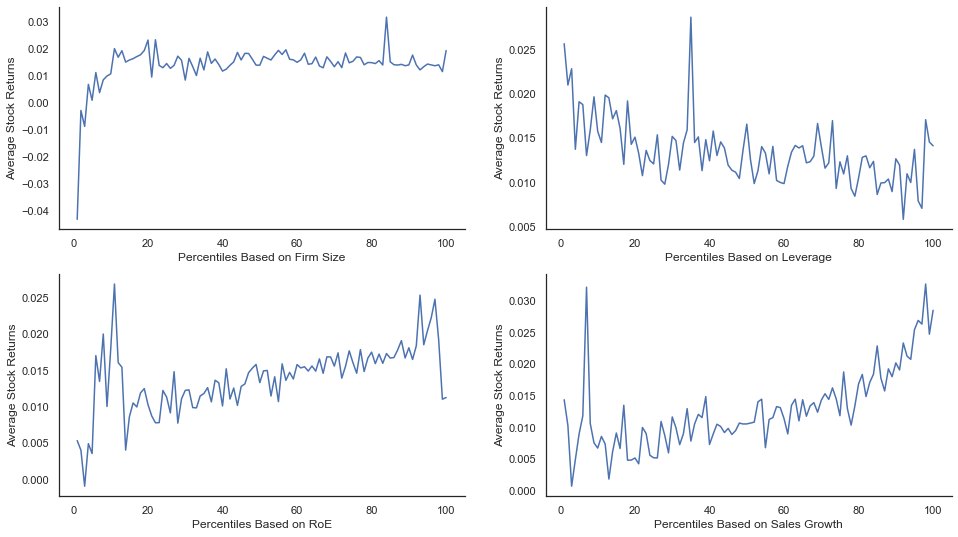

In [57]:
sns.set_theme(style='white')
fig, axe = plt.subplots(2,2, figsize=(16,9))

sns.lineplot(Marketcap, ax=axe[0,0], legend=False)
axe[0,0].set_xlabel('Percentiles Based on Firm Size')
axe[0,0].set_ylabel('Average Stock Returns')

sns.lineplot(Levarage, ax=axe[0,1], legend=False)
axe[0,1].set_xlabel('Percentiles Based on Leverage')
axe[0,1].set_ylabel('Average Stock Returns')

sns.lineplot(RoE, ax=axe[1,0], legend=False)
axe[1,0].set_xlabel('Percentiles Based on RoE')
axe[1,0].set_ylabel('Average Stock Returns')

sns.lineplot(SaleGR, ax=axe[1,1], legend=False)
axe[1,1].set_xlabel('Percentiles Based on Sales Growth')
axe[1,1].set_ylabel('Average Stock Returns')
sns.despine()